In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/Assignment3

/content/drive/MyDrive/Colab Notebooks/Assignment3


In [4]:
!pip install pytorch-lightning
!pip install torchmetrics
!pip install einops
!pip install sounddevice
!pip install validators
!pip install PYSimpleGUI
!sudo apt-get install libportaudio2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 84.9 MB/s 
     |████████████████████████████████| 409 kB 88.9 MB/s 
     |████████████████████████████████| 140 kB 82.9 MB/s 
     |████████████████████████████████| 1.1 MB 60.5 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 83.6 MB/s 
     |████████████████████████████████| 271 kB 98.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [5]:
import torch
import torchaudio, torchvision
import os
import matplotlib.pyplot as plt 
import librosa
import argparse
import numpy as np
from pytorch_lightning import LightningModule, Trainer, LightningDataModule, Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy
from torchvision.transforms import ToTensor
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.datasets.speechcommands import load_speechcommands_item
from argparse import ArgumentParser
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import accuracy
from einops import rearrange
from torch import nn

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x

class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
      
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, 
            act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias) 
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer) 
   

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, dim, num_heads, num_blocks, mlp_ratio=4., qkv_bias=False,  
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, num_heads, mlp_ratio, qkv_bias, 
                                     act_layer, norm_layer) for _ in range(num_blocks)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x
        
def init_weights_vit_timm(module: nn.Module):
    """ ViT weight initialization, original timm impl (for reproducibility) """
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()

In [8]:
class SilenceDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(SilenceDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35
        path = os.path.join(self._path, torchaudio.datasets.speechcommands.EXCEPT_FOLDER)
        self.paths = [os.path.join(path, p) for p in os.listdir(path) if p.endswith('.wav')]

    def __getitem__(self, index):
        index = np.random.randint(0, len(self.paths))
        filepath = self.paths[index]
        waveform, sample_rate = torchaudio.load(filepath)
        return waveform, sample_rate, "silence", 0, 0

    def __len__(self):
        return self.len

class UnknownDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(UnknownDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35

    def __getitem__(self, index):
        index = np.random.randint(0, len(self._walker))
        fileid = self._walker[index]
        waveform, sample_rate, _, speaker_id, utterance_number = load_speechcommands_item(fileid, self._path)
        return waveform, sample_rate, "unknown", speaker_id, utterance_number

    def __len__(self):
        return self.len

class LitTransformer(LightningModule):
    def __init__(self, num_classes=37, lr=0.001, max_epochs=30, depth=12, embed_dim=64,
                 head=4, patch_dim=192, seqlen=64, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Transformer(dim=embed_dim, num_heads=head, num_blocks=depth, mlp_ratio=4.,
                                   qkv_bias=False, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
        self.embed = torch.nn.Linear(patch_dim, embed_dim)

        self.fc = nn.Linear(seqlen * embed_dim, num_classes)
        self.loss = torch.nn.CrossEntropyLoss()
        
        self.reset_parameters()


    def reset_parameters(self):
        init_weights_vit_timm(self)
    

    def forward(self, x):
        # Linear projection
        x = self.embed(x)
            
        # Encoder
        x = self.encoder(x)
        x = x.flatten(start_dim=1)

        # Classification head
        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        mels, labels = batch
        #print(f'mels: {mels} shape: {mels.shape}')
        preds = self(mels)
        loss = self.loss(preds,labels)
        #print(f'preds: {preds} labels: {labels}')
        return loss

    def test_step(self, batch, batch_idx):
        mels, labels  = batch
        #print(f'mels: {mels} shape: {mels.shape}')
        preds = self(mels)
        loss = self.loss(preds, labels)
        acc = accuracy(preds, labels)
        return {"preds": preds, 'test_loss': loss, 'test_acc': acc}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc*100., on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self.test_epoch_end(outputs)

class KWSDataModule(LightningDataModule):
    def __init__(self, path, batch_size=32, num_workers=4, n_fft=1024, 
                 n_mels=128, win_length=None, hop_length=512, patch_num=8 , class_dict={}, 
                 **kwargs):
        super().__init__(**kwargs)
        self.path = path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.class_dict = class_dict
        self.patch_num = patch_num

    def prepare_data(self):
        self.train_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                                download=True,
                                                                subset='training')

        silence_dataset = SilenceDataset(self.path)
        unknown_dataset = UnknownDataset(self.path)
        self.train_dataset = torch.utils.data.ConcatDataset([self.train_dataset, silence_dataset, unknown_dataset])
                                                                
        self.val_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                              download=True,
                                                              subset='validation')
        self.test_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                               download=True,
                                                               subset='testing')                                                    
        _, sample_rate, _, _, _ = self.train_dataset[0]
        self.sample_rate = sample_rate
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                              n_fft=self.n_fft,
                                                              win_length=self.win_length,
                                                              hop_length=self.hop_length,
                                                              n_mels=self.n_mels,
                                                              power=2.0)

    def setup(self, stage=None):
        self.prepare_data()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            collate_fn=self.collate_fn
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        mels = []
        labels = []
        wavs = []
        for sample in batch:
            waveform, sample_rate, label, speaker_id, utterance_number = sample
            # ensure that all waveforms are 1sec in length; if not pad with zeros
            if waveform.shape[-1] < sample_rate:
                waveform = torch.cat([waveform, torch.zeros((1, sample_rate - waveform.shape[-1]))], dim=-1)
            elif waveform.shape[-1] > sample_rate:
                waveform = waveform[:,:sample_rate]

            # mel from power to db
            mels.append(ToTensor()(librosa.power_to_db(self.transform(waveform).squeeze().numpy(), ref=np.max)))
            labels.append(torch.tensor(self.class_dict[label]))
            wavs.append(waveform)

        mels = torch.stack(mels, dim=0)
        mels = rearrange(mels, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=self.patch_num, p2=self.patch_num)

        #labels = torch.stack(labels)
        labels = torch.LongTensor(labels)

        wavs = torch.stack(wavs)
   
        return mels, labels

In [48]:
def get_args():
    parser = argparse.ArgumentParser()
    # model training hyperparameters
    parser.add_argument('--batch-size', type=int, default=32, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--max-epochs', type=int, default=40, metavar='N',
                        help='number of epochs to train (default: 30)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')

    # where dataset will be stored
    parser.add_argument("--path", type=str, default="/data/speech_commands/")

    # 35 keywords + silence + unknown
    parser.add_argument("--num-classes", type=int, default=37)
   
    # mel spectrogram parameters
    parser.add_argument("--n-fft", type=int, default=1024)
    parser.add_argument("--n-mels", type=int, default=128)
    parser.add_argument("--win-length", type=int, default=None)
    parser.add_argument("--hop-length", type=int, default=512)

    # 16-bit fp model to reduce the size
    parser.add_argument("--precision", default=16)
    parser.add_argument("--accelerator", default='gpu')
    parser.add_argument("--devices", default=1)
    parser.add_argument("--num-workers", type=int, default=4)

    # transformer parameters
    parser.add_argument('--embed_dim', type=int, default=64, help='embedding dimension')
    parser.add_argument('--patch_num', type=int, default=8, help='patch_num')
    parser.add_argument('--depth', type=int, default=12, help='depth')
    parser.add_argument('--num_heads', type=int, default=4, help='num_heads')

    args = parser.parse_args("")
    return args

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

if __name__ == "__main__":

    args = get_args()
    CLASSES = ['silence', 'unknown', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
               'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no',
               'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
               'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
    
    # make a dictionary from CLASSES to integers
    CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

    if not os.path.exists(args.path):
        os.makedirs(args.path, exist_ok=True)

    datamodule = KWSDataModule(batch_size=args.batch_size, num_workers=args.num_workers,
                               path=args.path, n_fft=args.n_fft, n_mels=args.n_mels,
                               win_length=args.win_length, hop_length=args.hop_length,
                               class_dict=CLASS_TO_IDX)
    datamodule.prepare_data()

    data = iter(datamodule.train_dataloader()).next()
    patch_dim = data[0].shape[-1]
    seqlen = data[0].shape[-2]
    print("Embed dim:", args.embed_dim)
    print("Patch num:", args.patch_num)
    print("Sequence length:", seqlen)

    model = LitTransformer(num_classes=args.num_classes, lr=args.lr, epochs=args.max_epochs, 
                           depth=args.depth, embed_dim=args.embed_dim, head=args.num_heads,
                           patch_dim=patch_dim, seqlen=seqlen,)
    
    trainer = Trainer(accelerator=args.accelerator, devices=args.devices, max_epochs=args.max_epochs, precision=16 if args.accelerator == 'gpu' else 32, detect_anomaly = True)
    trainer.fit(model, datamodule=datamodule)
    #trainer.fit(model, datamodule=datamodule, ckpt_path ='./lightning_logs/version_49/checkpoints/epoch=29-step=84090.ckpt')

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Embed dim: 64
Patch num: 8
Sequence length: 64


Restoring states from the checkpoint path at ./lightning_logs/version_49/checkpoints/epoch=29-step=84090.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:343: UserWarning: The dirpath has changed from '/content/drive/MyDrive/Colab Notebooks/Assignment3/lightning_logs/version_49/checkpoints' to '/content/drive/MyDrive/Colab Notebooks/Assignment3/lightning_logs/version_51/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  f"The dirpath has changed from {dirpath_from_ckpt!r} to {self.dirpath!r},"
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | Transformer      | 597 K 
1 | embed   | Linear           | 4.2 K 
2 | fc      | Linear           | 151 K 
3 | loss    | CrossEntropyLoss | 0     
----------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 2803it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [50]:
trainer.test(model, datamodule=datamodule)
trainer.save_checkpoint('./checkpoint.ckpt')
print('saved checkpoint.ckpt')
model = model.load_from_checkpoint('./checkpoint.ckpt')
model.eval()
script = model.to_torchscript()
# save for use in kws-infer
model_path = './transformer-kws.pt'
torch.jit.save(script, model_path)
print('saved transformer-kws.pt')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             82.02372741699219
        test_loss           0.6939297318458557
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
saved checkpoint.ckpt
saved transformer-kws.pt


sample input: (tensor([[ 0.0176,  0.0178,  0.0183,  ..., -0.0201, -0.0197, -0.0194]]), 16000, 'no', '6e916de8', 0)


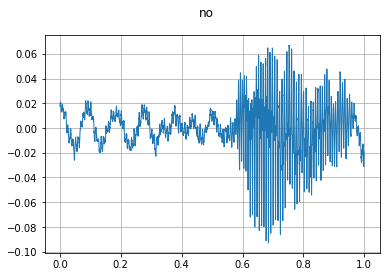

   ground truth: no 	model prediction: no


In [53]:
# model prediction from a random sample in the test dataset
sample = datamodule.test_dataset[np.random.randint(0,len(datamodule.test_dataset))] 
print(f'sample input: {sample}')
plot_waveform(sample[0],sample[1],sample[2])
transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample[1],
                                                     n_fft=args.n_fft,
                                                     win_length=args.win_length,
                                                     hop_length=args.hop_length,
                                                     n_mels=args.n_mels,
                                                     power=2.0)
waveform = sample[0][0]
if waveform.shape[-1] < 16000:
  waveform = torch.cat([waveform, torch.zeros((16000 - waveform.shape[-1]))], dim=-1)
elif waveform.shape[-1] > 16000:
  waveform = waveform[:,:16000]
mel = ToTensor()(librosa.power_to_db(transform(waveform).squeeze().numpy(), ref=np.max))
mel = rearrange(mel, 'c (p1 h) (p2 w) -> 1 (p1 p2) (c h w)', p1=8, p2=8)
scripted_module = torch.jit.load('transformer-kws.pt')
pred = scripted_module(mel)
pred = torch.argmax(pred, dim=1)
print(f'   ground truth: {sample[2]} \tmodel prediction: {CLASSES[pred]}')